In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gekko import GEKKO


In [16]:
df = pd.read_csv('/Users/ritikkotak/Desktop/temperature_record_recovered.csv')
df.head()

,1742797109,22.26563,22.01563,22.10938,(2021,1,1.1,0,1.2,24,4,1)
0,1742797109,22.25781,22.00781,22.11719,(2021,1,1,0,1,25,4,1)
1,1742797109,22.20313,21.92969,22.06250,(2021,1,1,0,1,30,4,1)
2,1742797109,22.20313,21.93750,22.02344,(2021,1,1,0,1,31,4,1)
3,1742797109,22.14063,21.95313,22.01563,(2021,1,1,0,1,36,4,1)
4,1742797109,22.14063,21.99219,22.03906,(2021,1,1,0,1,37,4,1)


In [17]:
# 1. see what pandas thinks your columns are
print(df.columns)
# → you’ll see something like Index(['1742797108.6068327', '22.26563', …], dtype='object')

# 2. rename the timestamp column
df = df.rename(columns={df.columns[0]: 'ts'})

# 3. convert to numeric (just in case)
df['ts'] = pd.to_numeric(df['ts'], errors='raise')

# 4a. simplest: compute span in hours from raw seconds
hours = (df['ts'].max() - df['ts'].min()) / 3600
print(f"Recorded over {hours:.2f} hours")


Index(['1742797109', '22.26563', '22.01563', '22.10938', '(2021', '1', '1.1',
       '0', '1.2', '24', '4', ' 1)'],
      dtype='object')
Recorded over 35.08 hours


In [10]:
df2= pd.read_csv('/Users/ritikkotak/Desktop/accelerometer_output.csv')

In [11]:
df2.head()

,1742797090.584397,0.09656503051519394,-0.0029408757109194994,0.10767004638910294,-0.0031553038861602545,-0.15479439496994019,-0.9949813485145569,27.487388610839844,0.0002633955155033618,-0.00012365546717774123,0.0005600146832875907,-0.00019892533600796014,-0.000623438972979784
0,1.742797e+09,0.064507,-0.002580,0.103534,-0.003371,-0.003926,-0.995009,27.488487,0.000559,-0.000170,0.000261,-0.000119,-0.000115
1,1.742797e+09,0.069599,0.000446,0.138816,-0.001540,-0.037806,-0.998234,27.488976,0.000274,0.000061,0.001006,-0.000057,-0.000251
2,1.742797e+09,0.147041,0.000406,0.096641,-0.002467,-0.118143,-0.997910,27.489464,0.001019,0.000036,0.000339,-0.000141,-0.000730
3,1.742797e+09,0.127738,-0.002399,0.150463,-0.002761,-0.160734,-0.994426,27.489708,0.000418,-0.000150,0.000890,-0.000173,-0.000516
4,1.742797e+09,0.104572,-0.002187,0.157154,-0.003356,0.072460,-0.995563,27.490074,0.000532,-0.000128,0.000736,-0.000130,0.000404


In [12]:
ts = pd.to_numeric(df2.iloc[:, 0], errors='raise')

# 2. compute total span in seconds
span_seconds = ts.max() - ts.min()

# 3. convert to hours
span_hours = span_seconds / 3600.0
print(f"Accelerometer data spans {span_hours:.2f} hours")

Accelerometer data spans 35.09 hours


In [4]:
COL = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2', '#59A14F', '#EDC948', '#B07AA1','#FF9DA7', '#9C755F', '#BAB0AC']

apm 192.159.179.95_gk_model10 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.3
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :           28
   Intermediates:           12
   Connections  :            0
   Equations    :           14
   Residuals    :            2
 
 Number of state variables:            264
 Number of total equations: -          240
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :             24
 
 ----------------------------------------------
 Model Parameter Estimation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  1.14524E+02  2.95049E+00
    1  9.46215E+01  5.42973E-01
    2  9.41610E+01  1.33706E-01

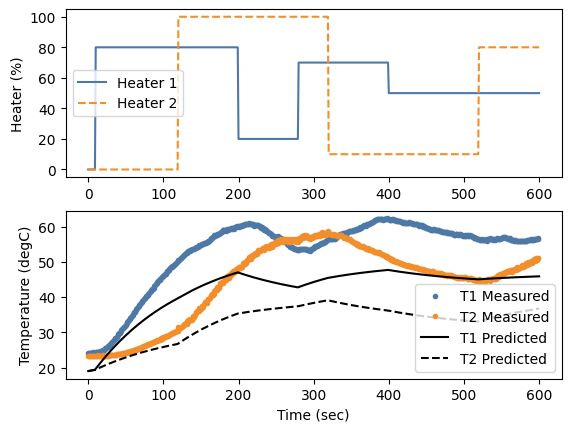

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from gekko import GEKKO

import time

# -------------------------------------
# import or generate data
# -------------------------------------
filename = '/Users/ritikkotak/Desktop/tclab_ss_data2.csv'
try:
    try:
        data = pd.read_csv(filename)
    except:
        url = 'https://apmonitor.com/do/uploads/Main/tclab_ss_data2.txt'
        data = pd.read_csv(url)
except:
    # generate training data if data file not available
    import tclab
    # Connect to Arduino
    a = tclab.TCLab()
    fid = open(filename,'w')
    fid.write('Heater 1,Heater 2,Temperature 1,Temperature 2\n')
    fid.close()
    # data collection takes 6 hours = 120 pts * 3 minutes each
    npts = 120
    for i in range(npts):
        # set random heater values
        Q1 = np.random.rand()*100
        Q2 = np.random.rand()*100
        a.Q1(Q1)
        a.Q2(Q2)
        print('Heater 1: ' + str(Q1) + ' %')
        print('Heater 2: ' + str(Q2) + ' %')
        # wait 3 minutes
        time.sleep(3*60)
        # record temperature and heater value
        print('Temperature 1: ' + str(a.T1) + ' degC')
        print('Temperature 2: ' + str(a.T2) + ' degC')
        fid = open(filename,'a')
        fid.write(str(Q1)+','+str(Q2)+','+str(a.T1)+','+str(a.T2)+'\n')
        fid.close()
    # close connection to Arduino
    a.close()
    # read data file
    data = pd.read_csv(filename)

# -------------------------------------
# scale data
# -------------------------------------
s = MinMaxScaler(feature_range=(0,1))
sc_train = s.fit_transform(data)

# partition into inputs and outputs
xs = sc_train[:,0:2] # 2 heaters
ys = sc_train[:,2:4] # 2 temperatures

# -------------------------------------
# build neural network
# -------------------------------------
nin = 2  # inputs
n1 = 2   # hidden layer 1 (linear)
n2 = 2   # hidden layer 2 (nonlinear)
n3 = 2   # hidden layer 3 (linear)
nout = 2 # outputs

# Initialize gekko models
train = GEKKO() 
dyn   = GEKKO()
model = [train,dyn]

for m in model:
    # use APOPT solver
    m.options.SOLVER = 1

    # input(s)
    m.inpt = [m.Param() for i in range(nin)]

    # layer 1 (linear)
    m.w1 = m.Array(m.FV, (nout,nin,n1))
    m.l1 = [[m.Intermediate(sum([m.w1[k,j,i]*m.inpt[j] \
            for j in range(nin)])) for i in range(n1)] \
            for k in range(nout)]

    # layer 2 (tanh)
    m.w2 = m.Array(m.FV, (nout,n1,n2))
    m.l2 = [[m.Intermediate(sum([m.tanh(m.w2[k,j,i]*m.l1[k][j]) \
            for j in range(n1)])) for i in range(n2)] \
            for k in range(nout)]

    # layer 3 (linear)
    m.w3 = m.Array(m.FV, (nout,n2,n3))
    m.l3 = [[m.Intermediate(sum([m.w3[k,j,i]*m.l2[k][j] \
            for j in range(n2)])) for i in range(n3)] \
            for k in range(nout)]

    # outputs
    m.outpt = [m.CV() for i in range(nout)]
    m.Equations([m.outpt[k]==sum([m.l3[k][i] for i in range(n3)]) \
                 for k in range(nout)])

    # flatten matrices
    m.w1 = m.w1.flatten()
    m.w2 = m.w2.flatten()
    m.w3 = m.w3.flatten()

# -------------------------------------
# fit parameter weights
# -------------------------------------
m = train
for i in range(nin):
    m.inpt[i].value=xs[:,i]
for i in range(nout):
    m.outpt[i].value = ys[:,i]
    m.outpt[i].FSTATUS = 1
for i in range(len(m.w1)):
    m.w1[i].FSTATUS=1
    m.w1[i].STATUS=1
    m.w1[i].MEAS=1.0
for i in range(len(m.w2)):
    m.w2[i].STATUS=1
    m.w2[i].FSTATUS=1
    m.w2[i].MEAS=0.5
for i in range(len(m.w3)):
    m.w3[i].FSTATUS=1
    m.w3[i].STATUS=1
    m.w3[i].MEAS=1.0
m.options.IMODE = 2
m.options.EV_TYPE = 2

# solve for weights to minimize loss (objective)
m.solve(disp=True)

# -------------------------------------
# generate dynamic predictions
# -------------------------------------
m = dyn
tf = 600
m.time = np.linspace(0,tf,tf+1)
# load neural network parameters
for i in range(len(m.w1)):
    m.w1[i].MEAS=train.w1[i].NEWVAL
    m.w1[i].FSTATUS = 1
for i in range(len(m.w2)):
    m.w2[i].MEAS=train.w2[i].NEWVAL
    m.w2[i].FSTATUS = 1
for i in range(len(m.w3)):
    m.w3[i].MEAS=train.w3[i].NEWVAL
    m.w3[i].FSTATUS = 1
# step tests
Q1d = np.zeros(tf+1)
Q1d[10:200] = 80
Q1d[200:280] = 20
Q1d[280:400] = 70
Q1d[400:] = 50
Q1 = m.Param()
Q1.value = Q1d

Q2d = np.zeros(tf+1)
Q2d[120:320] = 100
Q2d[320:520] = 10
Q2d[520:] = 80
Q2 = m.Param()
Q2.value = Q2d

# scaled inputs
m.inpt[0].value = Q1d * s.scale_[0] + s.min_[0]
m.inpt[1].value = Q2d * s.scale_[1] + s.min_[1] 

# define Temperature output
Q0 = 0   # initial heater
T0 = 19  # ambient temperature
# scaled steady state ouput
T1_ss = m.Var(value=T0)
T2_ss = m.Var(value=T0)
m.Equation(T1_ss == (m.outpt[0]-s.min_[2])/s.scale_[2])
m.Equation(T2_ss == (m.outpt[1]-s.min_[3])/s.scale_[3])
# dynamic prediction
T1 = m.Var(value=T0)
T2 = m.Var(value=T0)
# time constant
tau = m.Param(value=120) # determine in a later exercise
# additional model equation for dynamics
m.Equation(tau*T1.dt()==-(T1-T0)+(T1_ss-T0))
m.Equation(tau*T2.dt()==-(T2-T0)+(T2_ss-T0))

# solve dynamic simulation
m.options.IMODE=4
m.solve()

# generate step test data on Arduino
# -------------------------------------
# import or generate data
# -------------------------------------
filename = 'tclab_dyn_data2.csv'
try:
    try:
        data = pd.read_csv(filename)
    except:
        url = 'https://apmonitor.com/do/uploads/Main/tclab_dyn_data2.txt'
        data = pd.read_csv(url)
except:
    # generate training data if data file not available
    import tclab
    # Connect to Arduino
    a = tclab.TCLab()
    fid = open(filename,'w')
    fid.write('Time,H1,H2,T1,T2\n')
    fid.close()
    # check for cool down
    i = 0
    while i<=10:
        i += 1 # upper limit on wait time
        T1m = a.T1
        T2m = a.T2
        print('T1: ' + str(a.T1) + ' T2: ' + str(a.T2))
        print('Sleep 30 sec')
        time.sleep(30)
        if (a.T1<30 and a.T2<30 and a.T1>=T1m-0.2 and a.T2>=T2m-0.2):
            break  # continue when conditions met
        else:
            print('Not at ambient temperature')
    # run step test (10 min)
    for i in range(tf+1):
        # set heater values
        a.Q1(Q1d[i])
        a.Q2(Q2d[i])
        print('Time: ' + str(i) + \
              ' H1: ' + str(Q1d[i]) + \
              ' H2: ' + str(Q2d[i]) + \
              ' T1: ' + str(a.T1)   + \
              ' T2: ' + str(a.T2))
        # wait 1 second
        time.sleep(1)
        fid = open(filename,'a')
        fid.write(str(i)+','+str(Q1d[i])+','+str(Q2d[i])+',' \
                  +str(a.T1)+','+str(a.T2)+'\n')
        fid.close()
    # close connection to Arduino
    a.close()
    # read data file
    data = pd.read_csv(filename)

# plot prediction and measurement
plt.figure()
plt.subplot(2,1,1)
plt.plot(m.time,Q1.value,'-',color = COL[0],label='Heater 1')
plt.plot(m.time,Q2.value,'--',color = COL[1],label='Heater 2')
plt.ylabel('Heater (%)')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(data['Time'],data['T1'],'.',color = COL[0],label='T1 Measured')
plt.plot(data['Time'],data['T2'],'.',color = COL[1],label='T2 Measured')
plt.plot(m.time,T1.value,'k-',label='T1 Predicted')
plt.plot(m.time,T2.value,'k--',label='T2 Predicted')
plt.ylabel('Temperature (degC)')
plt.legend(loc='best')
plt.xlabel('Time (sec)')
plt.savefig('tclab_dyn_pred.png')

plt.show()

apm 192.159.179.95_gk_model13 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.3
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            1
   Variables    :           13
   Intermediates:            4
   Connections  :            0
   Equations    :            6
   Residuals    :            2
 
 Number of state variables:           4795
 Number of total equations: -         4792
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              3
 
 **********************************************
 Dynamic Estimation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains

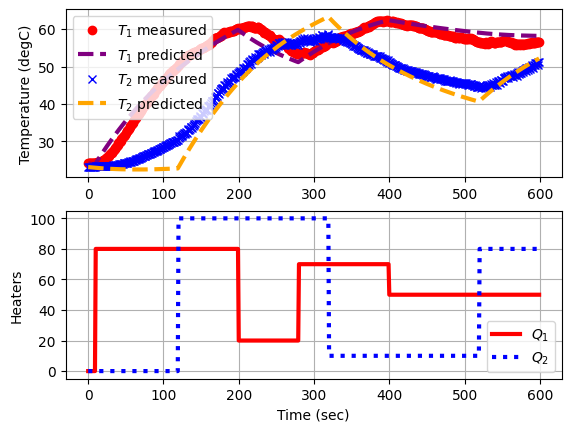

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from gekko import GEKKO

# Import or generate data
filename = 'tclab_dyn_data2.csv'
try:
    data = pd.read_csv(filename)
except:
    url = 'https://apmonitor.com/do/uploads/Main/tclab_dyn_data2.txt'
    data = pd.read_csv(url)

# Create GEKKO Model
m = GEKKO()
m.time = data['Time'].values

# Parameters to Estimate
U = m.FV(value=10,lb=1,ub=20)
alpha1 = m.FV(value=0.01,lb=0.003,ub=0.03)  # W / % heater
alpha2 = m.FV(value=0.005,lb=0.002,ub=0.02) # W / % heater

# STATUS=1 allows solver to adjust parameter
U.STATUS = 1  
alpha1.STATUS = 1 
alpha2.STATUS = 1 

# Measured inputs
Q1 = m.MV(value=data['H1'].values)
Q2 = m.MV(value=data['H2'].values)

# State variables
TC1 = m.CV(value=data['T1'].values)
TC1.FSTATUS = 1    # minimize fstatus * (meas-pred)^2
TC2 = m.CV(value=data['T2'].values)
TC2.FSTATUS = 1    # minimize fstatus * (meas-pred)^2

Ta = m.Param(value=19.0+273.15)     # K
mass = m.Param(value=4.0/1000.0)    # kg
Cp = m.Param(value=0.5*1000.0)      # J/kg-K    
A = m.Param(value=10.0/100.0**2)    # Area not between heaters in m^2
As = m.Param(value=2.0/100.0**2)    # Area between heaters in m^2
eps = m.Param(value=0.9)            # Emissivity
sigma = m.Const(5.67e-8)            # Stefan-Boltzmann

# Heater temperatures in Kelvin
T1 = m.Intermediate(TC1+273.15)
T2 = m.Intermediate(TC2+273.15)

# Heat transfer between two heaters
Q_C12 = m.Intermediate(U*As*(T2-T1)) # Convective
Q_R12 = m.Intermediate(eps*sigma*As*(T2**4-T1**4)) # Radiative

# Semi-fundamental correlations (energy balances)
m.Equation(TC1.dt() == (1.0/(mass*Cp))*(U*A*(Ta-T1) \
                    + eps * sigma * A * (Ta**4 - T1**4) \
                    + Q_C12 + Q_R12 \
                    + alpha1*Q1))

m.Equation(TC2.dt() == (1.0/(mass*Cp))*(U*A*(Ta-T2) \
                    + eps * sigma * A * (Ta**4 - T2**4) \
                    - Q_C12 - Q_R12 \
                    + alpha2*Q2))

# Options
m.options.IMODE   = 5 # MHE
m.options.EV_TYPE = 2 # Objective type
m.options.NODES   = 2 # Collocation nodes
m.options.SOLVER  = 3 # IPOPT

# Solve
m.solve(disp=True)

# Parameter values
print('U     : ' + str(U.value[0]))
print('alpha1: ' + str(alpha1.value[0]))
print('alpha2: ' + str(alpha2.value[0]))

# Create plot
plt.figure()
ax=plt.subplot(2,1,1)
ax.grid()
plt.plot(data['Time'],data['T1'],'ro',label=r'$T_1$ measured')
plt.plot(m.time,TC1.value,color='purple',linestyle='--',\
         lw=3,label=r'$T_1$ predicted')
plt.plot(data['Time'],data['T2'],'bx',label=r'$T_2$ measured')
plt.plot(m.time,TC2.value,color='orange',linestyle='--',\
         lw=3,label=r'$T_2$ predicted')
plt.ylabel('Temperature (degC)')
plt.legend(loc=2)
ax=plt.subplot(2,1,2)
ax.grid()
plt.plot(data['Time'],data['H1'],'r-',\
         lw=3,label=r'$Q_1$')
plt.plot(data['Time'],data['H2'],'b:',\
         lw=3,label=r'$Q_2$')
plt.ylabel('Heaters')
plt.xlabel('Time (sec)')
plt.legend(loc='best')
plt.show()

TCLab version 1.0.0
Arduino Leonardo connected on port /dev/cu.usbmodem1301 at 115200 baud.
TCLab Firmware 2.0.1 Arduino Leonardo/Micro.
000s | Heater:  90% | Temp: 23.77 °C
001s | Heater:  90% | Temp: 23.73 °C
002s | Heater:  90% | Temp: 23.64 °C
003s | Heater:  90% | Temp: 23.70 °C
004s | Heater:  90% | Temp: 23.64 °C
005s | Heater:  90% | Temp: 23.83 °C
006s | Heater:  90% | Temp: 23.80 °C
007s | Heater:  90% | Temp: 23.83 °C
008s | Heater:  90% | Temp: 23.86 °C
009s | Heater:  90% | Temp: 23.83 °C
010s | Heater:  90% | Temp: 23.96 °C
011s | Heater:  90% | Temp: 24.25 °C
012s | Heater:  90% | Temp: 24.19 °C
013s | Heater:  90% | Temp: 24.09 °C
014s | Heater:  90% | Temp: 24.44 °C
015s | Heater:  90% | Temp: 24.64 °C
016s | Heater:  90% | Temp: 24.51 °C
017s | Heater:  90% | Temp: 24.77 °C
018s | Heater:  90% | Temp: 24.93 °C
019s | Heater:  90% | Temp: 24.96 °C
020s | Heater:  90% | Temp: 25.28 °C
021s | Heater:  90% | Temp: 25.22 °C
022s | Heater:  90% | Temp: 25.60 °C
023s | Heate

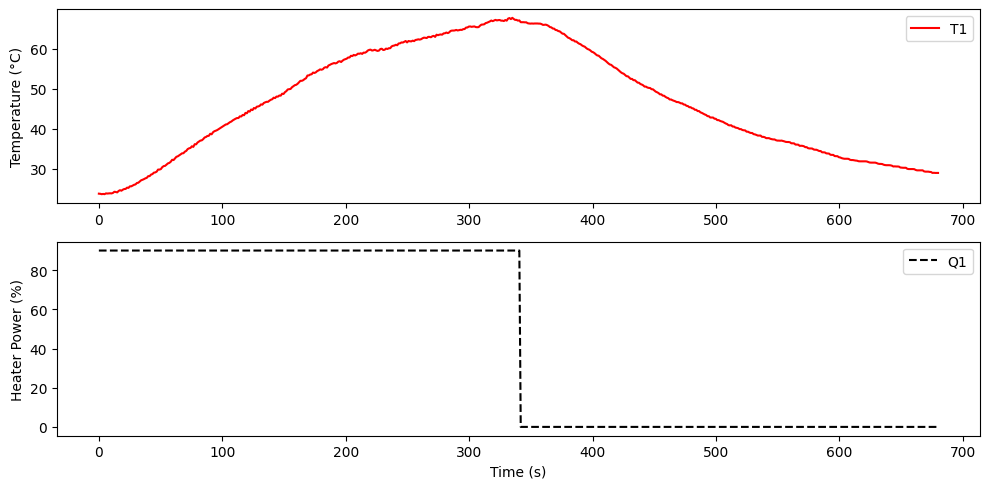

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tclab import TCLab

# Connect to the TCLab
lab = TCLab()

# Total run time in seconds
n = 600

# Initialize arrays for time, temperature, and heater values
T1_data = np.zeros(n)
Q1_data = np.zeros(n)
time_data = np.zeros(n)

try:
    # Start the timer
    start = time.time()

    for i in range(n):
        # Get elapsed time
        now = time.time()
        time_data[i] = now - start

        # Define heater pattern
        if i < 300:
            q = 90   # Heat
        else: 
            q = 0    # Cool
           # Reheat

        # Apply heater command
        lab.Q1(q)

        # Record data
        Q1_data[i] = q
        T1_data[i] = lab.T1

        # Display to console
        print(f"{i:03}s | Heater: {q:>3}% | Temp: {T1_data[i]:.2f} °C")

        # Wait 1 second
        time.sleep(1)

    # Turn off heater after run
    lab.Q1(0)

finally:
    # Always close the connection
    lab.close()

# Plot results
plt.figure(figsize=(10,5))

plt.subplot(2,1,1)
plt.plot(time_data, T1_data, 'r-', label='T1')
plt.ylabel('Temperature (°C)')
plt.legend()

plt.subplot(2,1,2)
plt.plot(time_data, Q1_data, 'k--', label='Q1')
plt.ylabel('Heater Power (%)')
plt.xlabel('Time (s)')
plt.legend()

plt.tight_layout()
plt.show()


/var/folders/dx/tkgvqd_562dfp_b406l_m3900000gn/T/ipykernel_66933/2194669550.py:36: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  rmse = np.sqrt(np.mean((np.array(T1.value) - T1_meas)**2))


U=5, RMSE=22.300
U=8, RMSE=22.300
U=10, RMSE=22.300
U=12, RMSE=22.300
U=15, RMSE=22.300


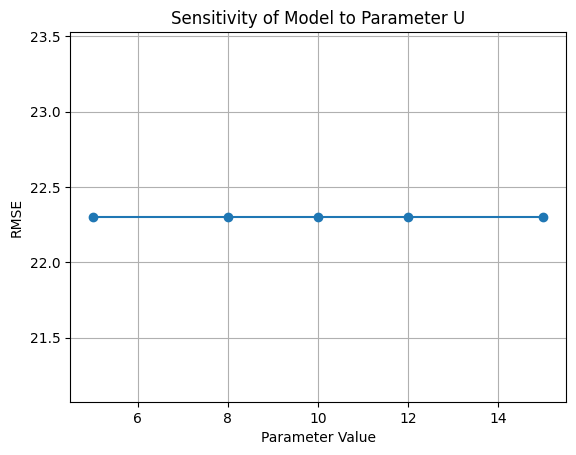

In [4]:




Q1_data = Q1_data
T1_meas = T1_data
time = time_data
T_ambient = T1_meas[0]


def test_param_sensitivity(param_name, test_values):
    errors = []
    for val in test_values:
        m = GEKKO(remote=False)
        m.time = time

        Q1 = m.Param(value=Q1_data)
        T_meas = m.Param(value=T1_meas)
        D = m.Param(value=0)
        T1 = m.Var(value=T_ambient)

        U = m.Param(value=10.0)
        alpha = m.Param(value=0.1)
        k_loss = m.Param(value=0.05)

        if param_name == 'U':
            U = m.Param(value=val)
        elif param_name == 'alpha':
            alpha = m.Param(value=val)
        elif param_name == 'k_loss':
            k_loss = m.Param(value=val)

        m.Equation(T1.dt() == k_loss*(alpha*Q1 + D - (T1 - T_ambient)))
        m.Obj((T1 - T_meas)**2)
        m.options.IMODE = 5
        try:
            m.solve(disp=False)
            rmse = np.sqrt(np.mean((np.array(T1.value) - T1_meas)**2))
        except:
            rmse = np.nan
        errors.append((val, rmse))
    return errors

# Example: test sensitivity of U
results = test_param_sensitivity('U', [5, 8, 10, 12, 15])
for val, err in results:
    print(f'U={val}, RMSE={err:.3f}')

# Plot
vals, errs = zip(*results)
plt.plot(vals, errs, marker='o')
plt.xlabel('Parameter Value')
plt.ylabel('RMSE')
plt.title('Sensitivity of Model to Parameter U')
plt.grid(True)
plt.show()


PARAMETER ESTIMATION: GEKKO ESTIMATION

apm 129.97.124.237_gk_model22 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.3
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            1
   Variables    :           13
   Intermediates:            4
   Connections  :            0
   Equations    :            6
   Residuals    :            2
 
 Number of state variables:           4795
 Number of total equations: -         4792
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              3
 
 **********************************************
 Dynamic Estimation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains

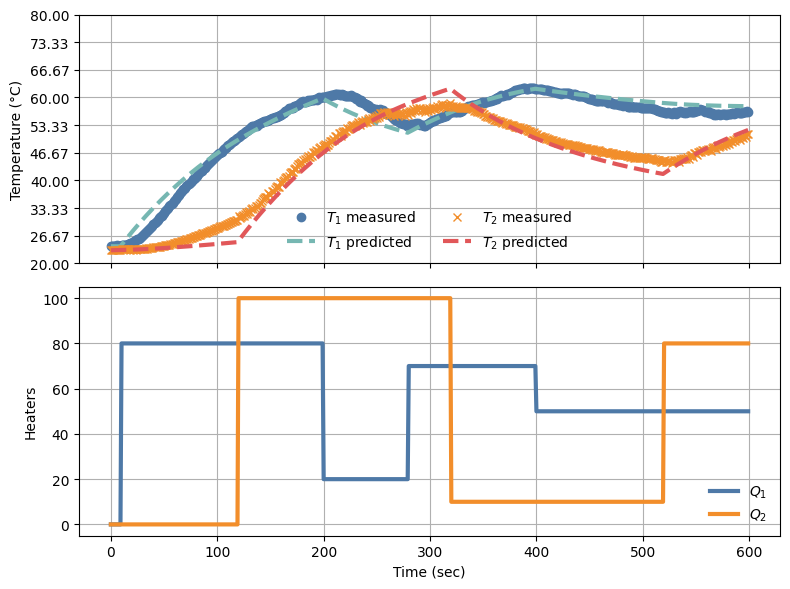

In [35]:
data = pd.read_csv('/Users/ritikkotak/Desktop/tclab_dyn_data2.csv')

# Create GEKKO Model
m = GEKKO()
m.time = data['Time'].values

# Parameters to Estimate
U = m.FV(value=10,lb=1,ub=20)
alpha1 = m.FV(value=0.01,lb=0.003,ub=0.03)  # W / % heater
alpha2 = m.FV(value=0.005,lb=0.002,ub=0.02) # W / % heater

# STATUS=1 allows solver to adjust parameter
U.STATUS = 1  
alpha1.STATUS = 1 
alpha2.STATUS = 1 

# Measured inputs
Q1 = m.MV(value=data['H1'].values)
Q2 = m.MV(value=data['H2'].values)

# State variables
TC1 = m.CV(value=data['T1'].values)
TC1.FSTATUS = 1    # minimize fstatus * (meas-pred)^2
TC2 = m.CV(value=data['T2'].values)
TC2.FSTATUS = 1    # minimize fstatus * (meas-pred)^2

# Heater temperatures in Kelvin
T1 = m.Intermediate(TC1+273.15)
T2 = m.Intermediate(TC2+273.15)

Ta_value = data['T1'].values[0] + 273.15  # Ambient temperature in Kelvin   
Ta = m.Param(value= Ta_value)     # K
mass = m.Param(value=4.0/1000.0)    # kg
Cp = m.Param(value=0.5*1000.0)      # J/kg-K    
A = m.Param(value=10.0/100.0**2)    # Area not between heaters in m^2
As = m.Param(value=2.0/100.0**2)    # Area between heaters in m^2
eps = m.Param(value=0.9)            # Emissivity
sigma = m.Const(5.67e-8)            # Stefan-Boltzmann



# Heat transfer between two heaters
Q_C12 = m.Intermediate(U*As*(T2-T1)) # Convective
Q_R12 = m.Intermediate(eps*sigma*As*(T2**4-T1**4)) # Radiative

# Semi-fundamental correlations (energy balances)
m.Equation(TC1.dt() == (1.0/(mass*Cp))*(U*A*(Ta-T1) \
                    + eps * sigma * A * (Ta**4 - T1**4) \
                    + Q_C12 + Q_R12 \
                    + alpha1*Q1))

m.Equation(TC2.dt() == (1.0/(mass*Cp))*(U*A*(Ta-T2) \
                    + eps * sigma * A * (Ta**4 - T2**4) \
                    - Q_C12 - Q_R12 \
                    + alpha2*Q2))

# Options
m.options.IMODE   = 5 # MHE
m.options.EV_TYPE = 2 # Objective type
m.options.NODES   = 2 # Collocation nodes
m.options.SOLVER  = 3 # IPOPT

# Solve
m.solve(disp=True)

# Parameter values
print('U     : ' + str(U.value[0]))
print('alpha1: ' + str(alpha1.value[0]))
print('alpha2: ' + str(alpha2.value[0]))




# Define major ticks for the temperature axis
ymin, ymax = 20, 80
major_ticks = np.linspace(ymin, ymax, 10)

# Create figure + two vertically stacked subplots
fig, axes = plt.subplots(
    2, 1,
    figsize=(8, 6),
    sharex=True
)

# --- Top subplot: temperatures ---
ax1 = axes[0]
ax1.plot(
    data['Time'], data['T1'],
    marker='o', linestyle='',
    color='#4E79A7',
    label=r'$T_1$ measured'
)
ax1.plot(
    m.time, TC1.value,
    linestyle='--', linewidth=3,
    color=COL[3],
    label=r'$T_1$ predicted'
)
ax1.plot(
    data['Time'], data['T2'],
    marker='x', linestyle='',
    color='#F28E2B',
    label=r'$T_2$ measured'
)
ax1.plot(
    m.time, TC2.value,
    linestyle='--', linewidth=3,
    color=COL[2],
    label=r'$T_2$ predicted'
)
ax1.set_ylabel('Temperature (°C)')
ax1.set_yticks(major_ticks)
ax1.grid(True)
ax1.legend(loc='lower center', ncol=2, frameon=False)

# --- Bottom subplot: heater outputs ---
ax2 = axes[1]
ax2.plot(
    data['Time'], data['H1'],
    linestyle='-', linewidth=3,
    color=COL[0],
    label=r'$Q_1$'
)
ax2.plot(
    data['Time'], data['H2'],
    linestyle='-', linewidth=3,
    color=COL[1],
    label=r'$Q_2$'
)
ax2.set_ylabel('Heaters')
ax2.set_xlabel('Time (sec)')
ax2.grid(True)
ax2.legend(loc='best', frameon=False)

# Tidy up
plt.tight_layout()
plt.show()


In [27]:
print(data['T1'].iloc[0] + 273.15)

297.27099999999996


TCLab version 1.0.0
Arduino Leonardo connected on port /dev/cu.usbmodem11301 at 115200 baud.
TCLab Firmware 2.0.1 Arduino Leonardo/Micro.


<Figure size 1200x700 with 0 Axes>

apm 192.159.179.95_tclab-mhe <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.3
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            1
   Variables    :           13
   Intermediates:            4
   Connections  :            0
   Equations    :            6
   Residuals    :            2
 
 Number of state variables:            280
 Number of total equations: -          280
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 **********************************************
 Dynamic Estimation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains 

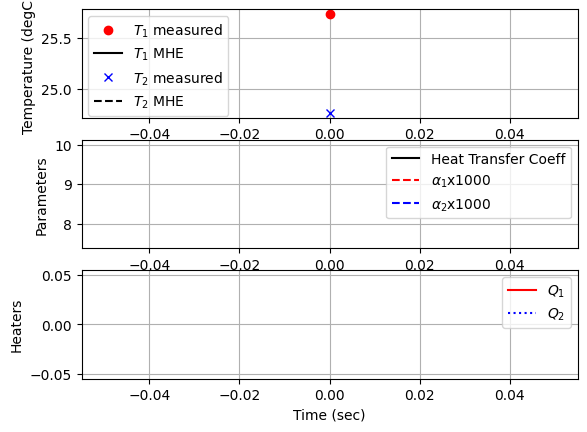

apm 192.159.179.95_tclab-mhe <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.3
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            1
   Variables    :           13
   Intermediates:            4
   Connections  :            0
   Equations    :            6
   Residuals    :            2
 
 Number of state variables:            280
 Number of total equations: -          280
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 **********************************************
 Dynamic Estimation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains 

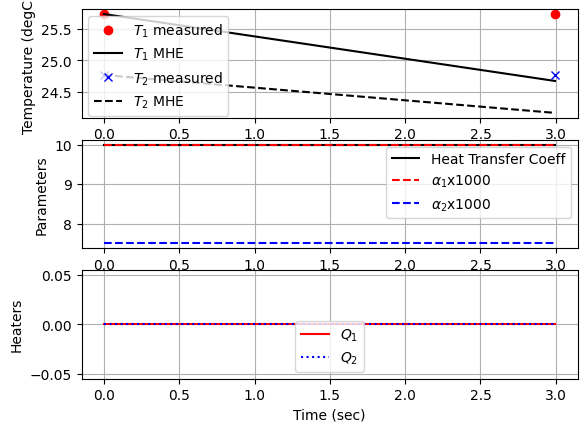

apm 192.159.179.95_tclab-mhe <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.3
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            1
   Variables    :           13
   Intermediates:            4
   Connections  :            0
   Equations    :            6
   Residuals    :            2
 
 Number of state variables:            280
 Number of total equations: -          280
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 **********************************************
 Dynamic Estimation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains 

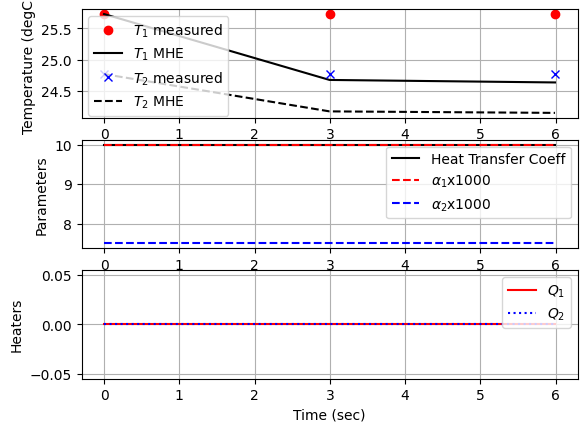

apm 192.159.179.95_tclab-mhe <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.3
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            1
   Variables    :           13
   Intermediates:            4
   Connections  :            0
   Equations    :            6
   Residuals    :            2
 
 Number of state variables:            280
 Number of total equations: -          280
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 **********************************************
 Dynamic Estimation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains 

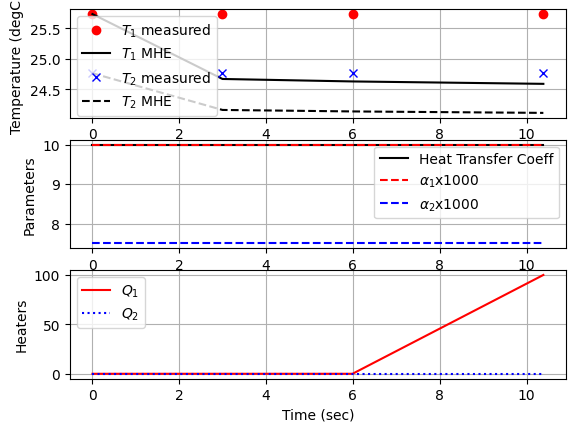

apm 192.159.179.95_tclab-mhe <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.3
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            1
   Variables    :           13
   Intermediates:            4
   Connections  :            0
   Equations    :            6
   Residuals    :            2
 
 Number of state variables:            280
 Number of total equations: -          280
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 **********************************************
 Dynamic Estimation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains 

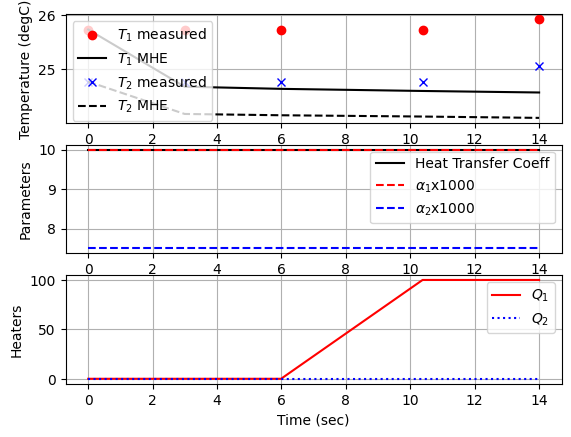

apm 192.159.179.95_tclab-mhe <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.3
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            1
   Variables    :           13
   Intermediates:            4
   Connections  :            0
   Equations    :            6
   Residuals    :            2
 
 Number of state variables:            280
 Number of total equations: -          280
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 **********************************************
 Dynamic Estimation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains 

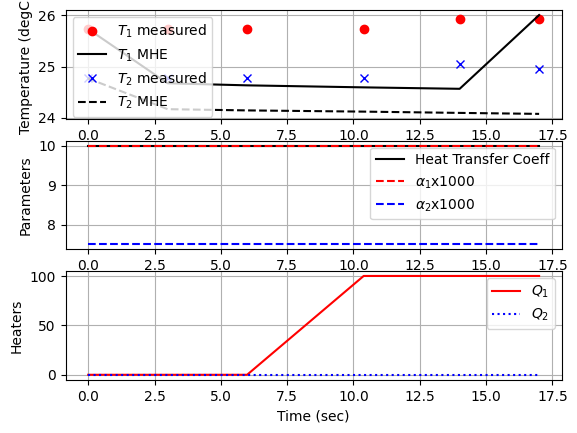

apm 192.159.179.95_tclab-mhe <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.3
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            1
   Variables    :           13
   Intermediates:            4
   Connections  :            0
   Equations    :            6
   Residuals    :            2
 
 Number of state variables:            280
 Number of total equations: -          280
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 **********************************************
 Dynamic Estimation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains 

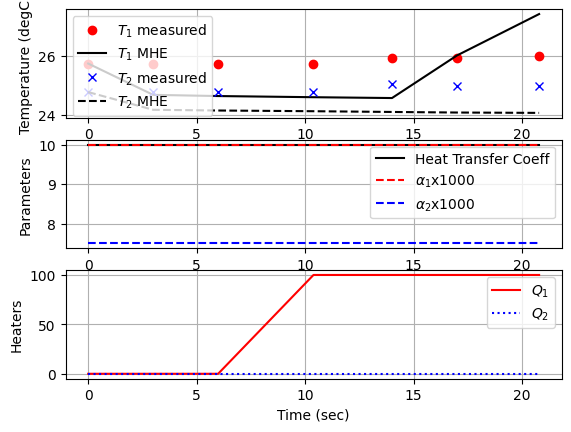

apm 192.159.179.95_tclab-mhe <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.3
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            1
   Variables    :           13
   Intermediates:            4
   Connections  :            0
   Equations    :            6
   Residuals    :            2
 
 Number of state variables:            280
 Number of total equations: -          280
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 **********************************************
 Dynamic Estimation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains 

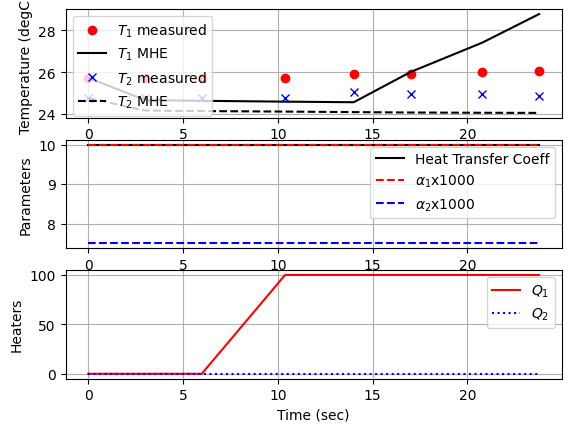

apm 192.159.179.95_tclab-mhe <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.3
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            1
   Variables    :           13
   Intermediates:            4
   Connections  :            0
   Equations    :            6
   Residuals    :            2
 
 Number of state variables:            280
 Number of total equations: -          280
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 **********************************************
 Dynamic Estimation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains 

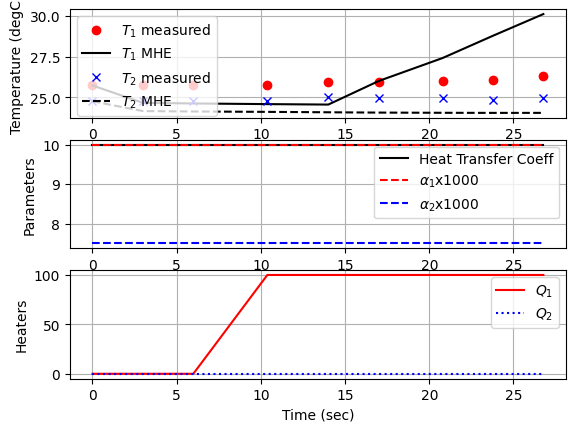

Shutting down
TCLab disconnected successfully.


<Figure size 640x480 with 0 Axes>

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import random
# get gekko package with:
#   pip install gekko
from gekko import GEKKO
# get tclab package with:
#   pip install tclab
from tclab import TCLab

# Connect to Arduino
a = TCLab()

# Make an MP4 animation?
make_mp4 = True  
if make_mp4:
    import imageio  # required to make animation
    import os
    try:
        os.mkdir('./figures')
    except:
        pass

# Final time
tf = 10 # min
# number of data points (1 pt every 3 seconds)
n = tf * 20 + 1

# Configure heater levels
# Percent Heater (0-100%)
Q1s = np.zeros(n)
Q2s = np.zeros(n)
# Heater random steps every 50 sec
# Alternate steps by Q1 and Q2
Q1s[3:]    = 100.0
Q1s[50:]   = 0.0 
Q1s[100:]  = 80.0

Q2s[25:]   = 60.0 
Q2s[75:]   = 100.0
Q2s[125:]  = 25.0

# rapid, random changes every 5 cycles between 50 and 100
for i in range(130,180):
    if i%10==0:
        Q1s[i:i+10] = random.random() * 100.0
    if (i+5)%10==0:
        Q2s[i:i+10] = random.random() * 100.0

# Record initial temperatures (degC)
T1m = a.T1 * np.ones(n)
T2m = a.T2 * np.ones(n)
# Store MHE values for plots
Tmhe1 = T1m[0] * np.ones(n)
Tmhe2 = T2m[0] * np.ones(n)
Umhe = 10.0 * np.ones(n)
amhe1 = 0.01 * np.ones(n)
amhe2 = 0.0075 * np.ones(n)

#########################################################
# Initialize Model as Estimator
#########################################################
# Use remote=False for local solve (Windows, Linux, ARM)
#     remote=True  for remote solve (All platforms)
m = GEKKO(name='tclab-mhe',remote=True)

# 60 second time horizon, 20 steps
m.time = np.linspace(0,60,21)

# Parameters to Estimate
U = m.FV(value=10,name='u')
U.STATUS = 0  # don't estimate initially
U.FSTATUS = 0 # no measurements
U.DMAX = 1
U.LOWER = 5
U.UPPER = 15

alpha1 = m.FV(value=0.01,name='a1')   # W / % heater
alpha1.STATUS = 0  # don't estimate initially
alpha1.FSTATUS = 0 # no measurements
alpha1.DMAX = 0.001
alpha1.LOWER = 0.003
alpha1.UPPER = 0.03

alpha2 = m.FV(value=0.0075,name='a2') # W / % heater
alpha2.STATUS = 0  # don't estimate initially
alpha2.FSTATUS = 0 # no measurements
alpha2.DMAX = 0.001
alpha2.LOWER = 0.002
alpha2.UPPER = 0.02


Cp = m.FV(value=0.5*1000.0)      # J/kg-K
Cp.STATUS = 0  # don't estimate
Cp.FSTATUS = 0 # no measurements
Cp.DMAX = 50
Cp.LOWER = 100
Cp.UPPER = 1000

# Measured inputs
Q1 = m.MV(value=0,name='q1')
Q1.STATUS = 0  # don't estimate
Q1.FSTATUS = 1 # receive measurement

Q2 = m.MV(value=0,name='q2')
Q2.STATUS = 0  # don't estimate
Q2.FSTATUS = 1 # receive measurement

# Measurements for model alignment
TC1 = m.CV(value=T1m[0],name='tc1')
TC1.STATUS = 1     # minimize error between simulation and measurement
TC1.FSTATUS = 1    # receive measurement
TC1.MEAS_GAP = 0.1 # measurement deadband gap
TC1.LOWER = 0
TC1.UPPER = 200

TC2 = m.CV(value=T2m[0],name='tc2')
TC2.STATUS = 1     # minimize error between simulation and measurement
TC2.FSTATUS = 1    # receive measurement
TC2.MEAS_GAP = 0.1 # measurement deadband gap
TC2.LOWER = 0
TC2.UPPER = 200

Ta = m.Param(value=23.0+273.15)     # K
mass = m.Param(value=4.0/1000.0)    # kg
# Cp = m.Param(value=0.5*1000.0)      # J/kg-K    
A = m.Param(value=10.0/100.0**2)    # Area not between heaters in m^2
As = m.Param(value=2.0/100.0**2)    # Area between heaters in m^2
eps = m.Param(value=0.9)            # Emissivity
sigma = m.Const(5.67e-8)            # Stefan-Boltzmann

# Heater temperatures
T1 = m.Intermediate(TC1+273.15)
T2 = m.Intermediate(TC2+273.15)

# Heat transfer between two heaters
Q_C12 = m.Intermediate(U*As*(T2-T1)) # Convective
Q_R12 = m.Intermediate(eps*sigma*As*(T2**4-T1**4)) # Radiative

# Semi-fundamental correlations (energy balances)
m.Equation(TC1.dt() == (1.0/(mass*Cp))*(U*A*(Ta-T1) \
                    + eps * sigma * A * (Ta**4 - T1**4) \
                    + Q_C12 + Q_R12 \
                    + alpha1*Q1))

m.Equation(TC2.dt() == (1.0/(mass*Cp))*(U*A*(Ta-T2) \
                    + eps * sigma * A * (Ta**4 - T2**4) \
                    - Q_C12 - Q_R12 \
                    + alpha2*Q2))

# Global Options
m.options.IMODE   = 5 # MHE
m.options.EV_TYPE = 2 # Objective type
m.options.NODES   = 3 # Collocation nodes
m.options.SOLVER  = 3 # IPOPT
m.options.COLDSTART = 1 # COLDSTART on first cycle
##################################################################
# Create plot
plt.figure(figsize=(12,7))
plt.ion()
plt.show()

# Main Loop
start_time = time.time()
prev_time = start_time
tm = np.zeros(n)

try:
    for i in range(1,n):
        # Sleep time
        sleep_max = 3.0
        sleep = sleep_max - (time.time() - prev_time)
        if sleep>=0.01:
            time.sleep(sleep-0.01)
        else:
            time.sleep(0.01)

        # Record time and change in time
        t = time.time()
        dt = t - prev_time
        prev_time = t
        tm[i] = t - start_time

        # Read temperatures in Celsius 
        T1m[i] = a.T1
        T2m[i] = a.T2

        # Insert measurements
        TC1.MEAS = T1m[i]
        TC2.MEAS = T2m[i]
        Q1.MEAS = Q1s[i-1]
        Q2.MEAS = Q2s[i-1]

        # Start estimating U after 10 cycles (20 sec)
        if i==10:
            U.STATUS = 1
            alpha1.STATUS = 1
            alpha2.STATUS = 1

        # Predict Parameters and Temperatures with MHE
        m.solve() 

        if m.options.APPSTATUS == 1:
            # Retrieve new values
            Tmhe1[i] = TC1.MODEL
            Tmhe2[i] = TC2.MODEL
            Umhe[i]  = U.NEWVAL
            amhe1[i] = alpha1.NEWVAL
            amhe2[i] = alpha2.NEWVAL
        else:
            # Solution failed, copy prior solution
            Tmhe1[i] = Tmhe1[i-1]
            Tmhe2[i] = Tmhe1[i-1]
            Umhe[i]  = Umhe[i-1]
            amhe1[i] = amhe1[i-1]
            amhe2[i] = amhe2[i-1]

        # Write new heater values (0-100)
        a.Q1(Q1s[i])
        a.Q2(Q2s[i])

        # Plot
        plt.clf()
        ax=plt.subplot(3,1,1)
        ax.grid()
        plt.plot(tm[0:i],T1m[0:i],'ro',label=r'$T_1$ measured')
        plt.plot(tm[0:i],Tmhe1[0:i],'k-',label=r'$T_1$ MHE')
        plt.plot(tm[0:i],T2m[0:i],'bx',label=r'$T_2$ measured')
        plt.plot(tm[0:i],Tmhe2[0:i],'k--',label=r'$T_2$ MHE')
        plt.ylabel('Temperature (degC)')
        plt.legend(loc=2)
        ax=plt.subplot(3,1,2)
        ax.grid()
        plt.plot(tm[0:i],Umhe[0:i],'k-',label='Heat Transfer Coeff')
        plt.plot(tm[0:i],amhe1[0:i]*1000,'r--',label=r'$\alpha_1$x1000')
        plt.plot(tm[0:i],amhe2[0:i]*1000,'b--',label=r'$\alpha_2$x1000')
        plt.ylabel('Parameters')
        plt.legend(loc='best')
        ax=plt.subplot(3,1,3)
        ax.grid()
        plt.plot(tm[0:i],Q1s[0:i],'r-',label=r'$Q_1$')
        plt.plot(tm[0:i],Q2s[0:i],'b:',label=r'$Q_2$')
        plt.ylabel('Heaters')
        plt.xlabel('Time (sec)')
        plt.legend(loc='best')
        plt.draw()
        plt.pause(0.05)
        if make_mp4:
            filename='./figures/plot_'+str(i+10000)+'.png'
            plt.savefig(filename)
        if make_mp4:
            filename = f'./figures/plot_{i:04d}.png'
            plt.savefig(filename,
                       dpi=150,
                       bbox_inches='tight')

    # Turn off heaters
    a.Q1(0)
    a.Q2(0)
    # Save figure
    plt.savefig('tclab_mhe.png')
    plt.tight_layout()
    plt.savefig('tclab_mhe.png',dpi=300,bbox_inches='tight')

    # generate mp4 from png figures in batches of 350
    if make_mp4:
        images = []
        iset = 0
        for i in range(1,n):
            filename='./figures/plot_'+str(i+10000)+'.png'
            images.append(imageio.imread(filename))
            if ((i+1)%350)==0:
                imageio.mimsave('results_'+str(iset)+'.mp4', images)
                iset += 1
                images = []
        if images!=[]:
            imageio.mimsave('results_'+str(iset)+'.mp4', images)

# Allow user to end loop with Ctrl-C           
except KeyboardInterrupt:
    # Disconnect from Arduino
    a.Q1(0)
    a.Q2(0)
    print('Shutting down')
    a.close()
    plt.savefig('tclab_mhe.png')

# Make sure serial connection still closes when there's an error
except:           
    # Disconnect from Arduino
    a.Q1(0)
    a.Q2(0)
    print('Error: Shutting down')
    a.close()
    plt.savefig('tclab_mhe.png')
    raise

In [4]:
import os
print("Working directory:", os.getcwd())

Working directory: /Users/ritikkotak/Desktop
